# Titanic - Machine Learning from Disaster

## Установка зависимостей

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

## Описание данных

- PassengerId - id пассажира
- Pclass - класс обслуживания билета (1 = первый, 2 = второй, 3 = третий)
- Name - имя пассажира
- Sex - пол пассажира
- Age - возраст пассажира
- SibSp - семейные отношения sibling/spouse)
- Parch - семейные отношения parent/child.
- Ticket - номер билета
- Fare - стоимость билета
- Cabin - номер кабины
- Embarked - Порт посадки. (C = Шербур, Q = Квинстаун, S = Саутгемптон)

Целевая переменная:
- Survived - Выжил человек или нет. 0 = Нет, 1 = Да.

## Загрузка датасета

In [3]:
train_data = pd.read_csv("../data/train.csv", index_col="PassengerId")
test_data = pd.read_csv("../data/test.csv", index_col="PassengerId")

In [4]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Анализ и предобработка данных

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [7]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


### Борьба с пропусками

In [9]:
data_nulls = train_data.isna().sum()
data_nulls

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [10]:
test_data_nulls = test_data.isna().sum()
test_data_nulls

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

<BarContainer object of 11 artists>

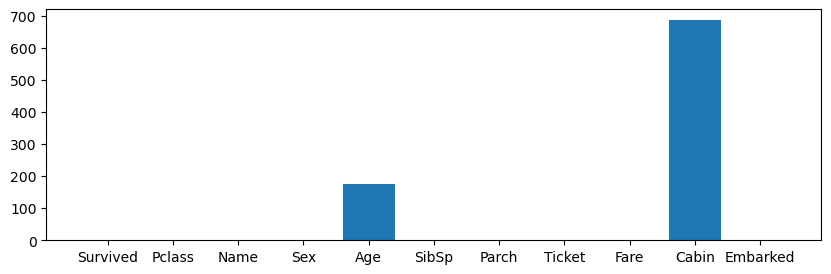

In [11]:
plt.figure(figsize=(10, 3))
plt.bar(data_nulls.index, data_nulls.values)

<Axes: xlabel='Age', ylabel='Count'>

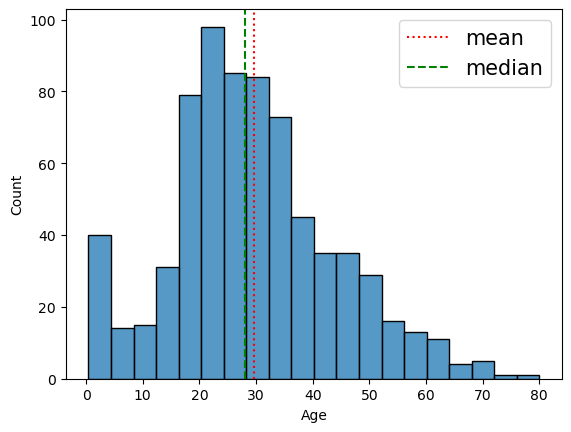

In [12]:
mean_Age = np.mean(train_data['Age'].dropna().values)
median_Age = np.quantile(train_data['Age'].dropna().values,q=0.5)
plt.axvline(x=mean_Age, color='r', linestyle = ':', label='mean')
plt.axvline(x=median_Age, color='g', linestyle = '--', label='median')
plt.legend(fontsize=15)
sns.histplot(train_data['Age'])

<Axes: xlabel='Cabin', ylabel='Count'>

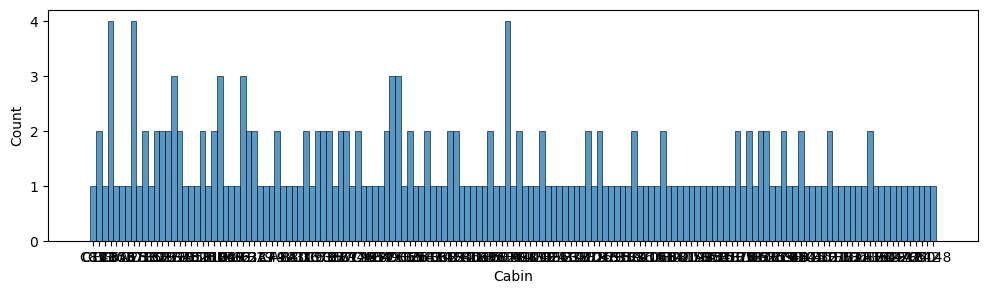

In [13]:
plt.figure(figsize=(12, 3))
sns.histplot(train_data['Cabin'])

<Axes: xlabel='Embarked', ylabel='Count'>

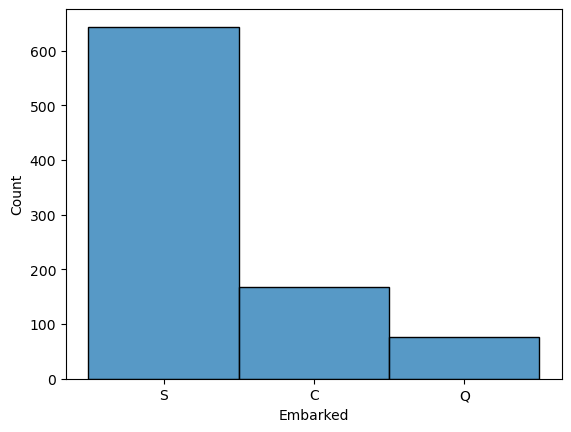

In [14]:
sns.histplot(train_data['Embarked'])

В датасете около 20% пропусков в Age, что мало для того, чтобы дропнуть столбец и много, чтобы дропнуть строчки с нулями в признаке.
Поэтому будем заполнять пропуски медианной. Тем более, что она примерно совпадает с модой распределения.
Столбец Cabin будет проще удалить, т.к. очень много пропусков и уникальных значений.
И также две строчки с пустыми Embarked заполним модами.Там более, что у нас и так ощутимое смещение в значение S. Мы не сделаем данные грязнее, при этом сохраним все строки.

In [15]:
train_data['Age'] = train_data['Age'].fillna(median_Age)

In [16]:
train_data = train_data.drop('Cabin', axis=1)
test_data = test_data.drop('Cabin', axis=1)

In [17]:
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])

In [18]:
data_nulls = train_data.isna().sum()
data_nulls

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

### Обработка 'Name'

В первоначальном виде столбец нельзя использовать, т.к. все данные уникальны. Но можно извлечь из него титулы.

In [19]:
for dataset in [train_data, test_data]:
    dataset['Title'] = dataset['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    
#Соберем все редкие титулы в один. И повторы типо Ms - Miss схлопнем. 
for dataset in [train_data, test_data]:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    #Удаляем Name
    dataset.drop("Name", axis=1, inplace = True)

train_data['Title'].value_counts()

Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64

Также удалим колонку "Ticket"

In [20]:
for dataset in [train_data, test_data]:
    dataset.drop("Ticket", axis=1, inplace = True)

In [21]:
test_data['Age'] = test_data['Age'].fillna(test_data.groupby(['Title', 'Pclass'])['Age'].transform('median'))

In [22]:
test_data['Fare'] = test_data['Fare'].fillna(test_data.groupby(['Title', 'Pclass'])['Fare'].transform('median'))

In [23]:
data_nulls = test_data.isna().sum()
data_nulls

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Title       0
dtype: int64

## Первая пробная модель - CatBoost

Попробуем обучить Титаник, пока не начал обрабатывать категориальные признаки и делать нормализацию.

In [24]:
y = train_data['Survived']
X = train_data.drop('Survived', axis=1)
X_test = test_data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
cat_features = ['Pclass', 'Sex', 'Embarked', 'Title']

In [26]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    cat_features=cat_features,
    random_seed=42,
    verbose=100,
    eval_metric='Accuracy'
)

In [27]:
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50,
    use_best_model=True,
)

0:	learn: 0.8047753	test: 0.7877095	best: 0.7877095 (0)	total: 86.2ms	remaining: 1m 26s
100:	learn: 0.9087079	test: 0.8212291	best: 0.8324022 (71)	total: 3.87s	remaining: 34.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8324022346
bestIteration = 71

Shrink model to first 72 iterations.


In [28]:
y_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.8324


Pclass: 20.01
Sex: 33.52
Age: 11.05
SibSp: 4.29
Parch: 3.56
Fare: 10.19
Embarked: 6.01
Title: 11.38


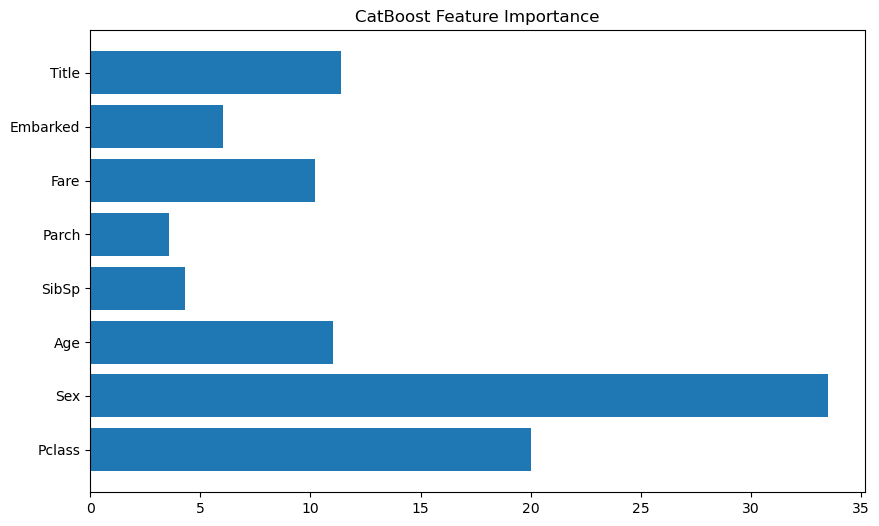

In [29]:
# Важность признаков
feature_importance = model.get_feature_importance()
feature_names = X.columns

for feature, importance in zip(feature_names, feature_importance):
    print(f"{feature}: {importance:.2f}")

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.title('CatBoost Feature Importance')
plt.show()

In [30]:
# Предсказания для submission
test_predictions = model.predict(X_test)

# Создаем файл для Kaggle
submission = pd.DataFrame({
    'PassengerId': test_data.index,
    'Survived': test_predictions
})

submission.to_csv('../data/catboost_baseline.csv', index=False)
print("Submission file created!")

Submission file created!


## Пайплайн для разных моделей

In [31]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Mr
2,1,1,female,38.0,1,0,71.2833,C,Mrs
3,1,3,female,26.0,0,0,7.9250,S,Miss
4,1,1,female,35.0,1,0,53.1000,S,Mrs
5,0,3,male,35.0,0,0,8.0500,S,Mr


In [32]:
num_features = ['Age', 'Fare', 'SibSp', 'Parch']
cat_features = ['Pclass', 'Sex', 'Embarked', 'Title']

base_preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
    ]
)

scaling_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
    ]
)

In [33]:
# 1. Линейные модели (требуют скалирования)
logreg_pipeline = Pipeline([
    ('preprocessor', scaling_preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

svm_pipeline = Pipeline([
    ('preprocessor', scaling_preprocessor),
    ('classifier', SVC(random_state=42, probability=True))
])

# 2. Деревья и ансамбли (не требуют скалирования)
rf_pipeline = Pipeline([
    ('preprocessor', base_preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

xgb_pipeline = Pipeline([
    ('preprocessor', base_preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# 3. CatBoost (сам обрабатывает категории)
catboost_pipeline = Pipeline([
    ('classifier', CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        cat_features=cat_features,
        random_seed=42,
        verbose=100,
        eval_metric='Accuracy'
        
    ))
])

In [34]:
models = {
    'Logistic Regression': logreg_pipeline,
    'SVM': svm_pipeline,
    'Random Forest': rf_pipeline,
    'XGBoost': xgb_pipeline,
    'CatBoost': catboost_pipeline
}

In [35]:
def evaluate_models(models, X_train, X_val, y_train, y_val):
    results = {}
    
    for name, model in models.items():
        print(f"🚀 Training {name}...")

        if 'CatBoost' in name:
            model.fit(
                X_train, y_train,
                classifier__eval_set=(X_val, y_val),
                classifier__early_stopping_rounds=50,
                classifier__use_best_model=True
            )

        else:
            # Обучение
            model.fit(X_train, y_train)
            
        # Предсказания
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Метрики
        accuracy = accuracy_score(y_val, y_pred)
        
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        print(f"✅ {name} - Accuracy: {accuracy:.4f}\n")
    
    return results

# Запускаем оценку
results = evaluate_models(models, X_train, X_val, y_train, y_val)



🚀 Training Logistic Regression...
✅ Logistic Regression - Accuracy: 0.8212

🚀 Training SVM...
✅ SVM - Accuracy: 0.8324

🚀 Training Random Forest...
✅ Random Forest - Accuracy: 0.8212

🚀 Training XGBoost...
✅ XGBoost - Accuracy: 0.8101

🚀 Training CatBoost...
0:	learn: 0.8047753	test: 0.7877095	best: 0.7877095 (0)	total: 35.3ms	remaining: 35.3s
100:	learn: 0.9087079	test: 0.8212291	best: 0.8324022 (71)	total: 3.75s	remaining: 33.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8324022346
bestIteration = 71

Shrink model to first 72 iterations.
✅ CatBoost - Accuracy: 0.8324



In [36]:
top_models = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)[:5]
print(f"\n🎯 Top models for tuning: {[name for name, _ in top_models]}")


🎯 Top models for tuning: ['SVM', 'CatBoost', 'Logistic Regression', 'Random Forest', 'XGBoost']


In [37]:
# Параметры для тюнинга
tuning_configs = {
    'Random Forest': {
        'pipeline': rf_pipeline,
        'params': {
            'classifier__n_estimators': [100, 200, 300, 500, 800],
            'classifier__max_depth': [None, 4, 7, 10, 20],
            "classifier__min_samples_leaf": [1, 2, 4, 8] 
        }
    },
    'XGBoost': {
        'pipeline': xgb_pipeline, 
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [2, 3, 6, 9],
            'classifier__learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'CatBoost': {
        'pipeline': catboost_pipeline,
        'params': {
            'classifier__iterations': [50, 75, 100, 200],
            'classifier__depth': [2, 4, 6, 9],
            'classifier__learning_rate': [0.03, 0.1, 0.15]
        }
    },
    'Logistic Regression': {
        'pipeline': Pipeline([
            ('preprocessor', scaling_preprocessor),  # для линейных моделей
            ('classifier', LogisticRegression(random_state=42, max_iter=1000))
        ]),
        'params': {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # сила регуляризации
            'classifier__penalty': ['l1', 'l2', 'elasticnet'],  # тип регуляризации
            'classifier__solver': ['liblinear', 'saga'],  # решатели для l1/elasticnet
            'classifier__l1_ratio': [0.1, 0.5, 0.9]  # только для elasticnet
        }
    },
    'SVM': {
        'pipeline': Pipeline([
            ('preprocessor', scaling_preprocessor),  # SVM очень чувствителен к масштабу
            ('classifier', SVC(random_state=42, probability=True))
        ]),
        'params': {
            'classifier__C': [0.1, 1, 10, 100],  # параметр регуляризации
            'classifier__kernel': ['linear', 'rbf', 'poly'],  # тип ядра
            'classifier__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # для rbf/poly
            'classifier__degree': [2, 3, 4]  # только для poly
        }
    }
}

# Тюнинг только лучших моделей
tuned_models = {}
for name in [name for name, _ in top_models]:
    if name in tuning_configs:
        print(f"🎛️ Tuning {name}...")
        
        grid_search = GridSearchCV(
            tuning_configs[name]['pipeline'],
            tuning_configs[name]['params'],
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        
        tuned_models[name] = {
            'model': grid_search.best_estimator_,
            'accuracy': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }
        
        print(f"✅ {name} - Best CV: {grid_search.best_score_:.4f}")
        print(f"🔧 Best params: {grid_search.best_params_}\n")

🎛️ Tuning SVM...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
✅ SVM - Best CV: 0.8301
🔧 Best params: {'classifier__C': 10, 'classifier__degree': 2, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}

🎛️ Tuning CatBoost...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
0:	learn: 0.8202247	total: 69.6ms	remaining: 3.41s
49:	learn: 0.8567416	total: 2.69s	remaining: 0us
✅ CatBoost - Best CV: 0.8273
🔧 Best params: {'classifier__depth': 9, 'classifier__iterations': 50, 'classifier__learning_rate': 0.1}

🎛️ Tuning Logistic Regression...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\Shurik\anaconda3\envs\ml_1\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
90 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Shurik\anaconda3\envs\ml_1\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shurik\anaconda3\envs\ml_1\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Shurik\anaconda3\envs\ml_1\Lib\site-packages\sklearn\pipeline.py", l

✅ Logistic Regression - Best CV: 0.8217
🔧 Best params: {'classifier__C': 10, 'classifier__l1_ratio': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

🎛️ Tuning Random Forest...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
✅ Random Forest - Best CV: 0.8315
🔧 Best params: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 500}

🎛️ Tuning XGBoost...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ XGBoost - Best CV: 0.8245
🔧 Best params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}



In [43]:
# Создаем ансамбль из НАСТРОЕННЫХ моделей
tuned_estimators = [
    (name, result['model']) 
    for name, result in tuned_models.items()
]

# Voting с настроенными моделями
voting_tuned = VotingClassifier(
    estimators=tuned_estimators,
    voting='soft'
)

# Обучаем и оцениваем
voting_tuned.fit(X_train, y_train)
y_pred_voting = voting_tuned.predict(X_val)
voting_accuracy = accuracy_score(y_val, y_pred_voting)

y_pred_voting = voting_tuned.predict(test_data)

submission = pd.DataFrame({
    'PassengerId': test_data.index,
    'Survived': final_predictions
})

submission.to_csv('voting_submission.csv', index=False)


print(f"🎯 Tuned Voting Ensemble Accuracy: {voting_accuracy:.4f}")

# Сравниваем с лучшей одиночной моделью
best_single_name = max(tuned_models.items(), key=lambda x: x[1]['accuracy'])[0]
best_single_accuracy = tuned_models[best_single_name]['accuracy']

print(f"🏆 Best single model ({best_single_name}): {best_single_accuracy:.4f}")
print(f"🤝 Tuned Voting Ensemble: {voting_accuracy:.4f}")
print(f"📈 Improvement: {voting_accuracy - best_single_accuracy:.4f}")

0:	learn: 0.8202247	total: 50.3ms	remaining: 2.46s
49:	learn: 0.8567416	total: 2.15s	remaining: 0us


C:\Users\Shurik\anaconda3\envs\ml_1\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


🎯 Tuned Voting Ensemble Accuracy: 0.8324
🏆 Best single model (Random Forest): 0.8315
🤝 Tuned Voting Ensemble: 0.8324
📈 Improvement: 0.0009


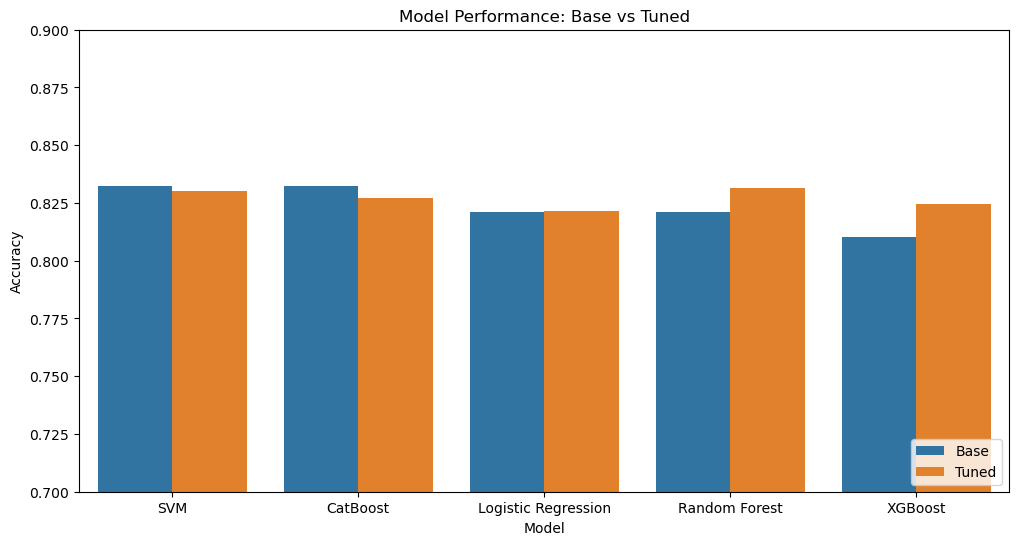

In [39]:
# Сравнение базовых vs настроенных моделей
comparison_data = []
for name in tuned_models.keys():
    comparison_data.append({
        'Model': name,
        'Stage': 'Base',
        'Accuracy': results[name]['accuracy']
    })
    comparison_data.append({
        'Model': name, 
        'Stage': 'Tuned',
        'Accuracy': tuned_models[name]['accuracy']
    })

comparison_df = pd.DataFrame(comparison_data)

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df, x='Model', y='Accuracy', hue='Stage')
plt.title('Model Performance: Base vs Tuned')
plt.ylim(0.7, 0.9)
plt.legend(loc='lower right')
plt.show()

In [40]:
# Выбираем лучшую модель
best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
best_model = results[best_model_name]['model']

print(f"🎯 Лучшая модель: {best_model_name}")

# Переобучаем на всех данных
if best_model_name != 'CatBoost':
    # Для пайплайнов с препроцессором
    best_model.fit(X, y)
else:
    # Для CatBoost
    best_model.fit(X, y, classifier__cat_features=categorical_features)

# Финальное предсказание
final_predictions = best_model.predict(test_data)

# Submission
submission = pd.DataFrame({
    'PassengerId': test_data.index,
    'Survived': final_predictions
})

submission.to_csv('final_submission.csv', index=False)

🎯 Лучшая модель: SVM


In [41]:
y_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.8547
